In [1]:
from aug_train import gen_augments
import torch 
import wandb
import numpy as np
from dataset_class import classes_RW, config
import onnxruntime
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniconda/base/envs/bzzt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nnarotam03 (shlongthesheep). Use `wandb login --relogin` to force relogin


In [2]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
wandb.login()

device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

Accuracy: 0.7390418929402638
F1 Score: 0.7409675107042392


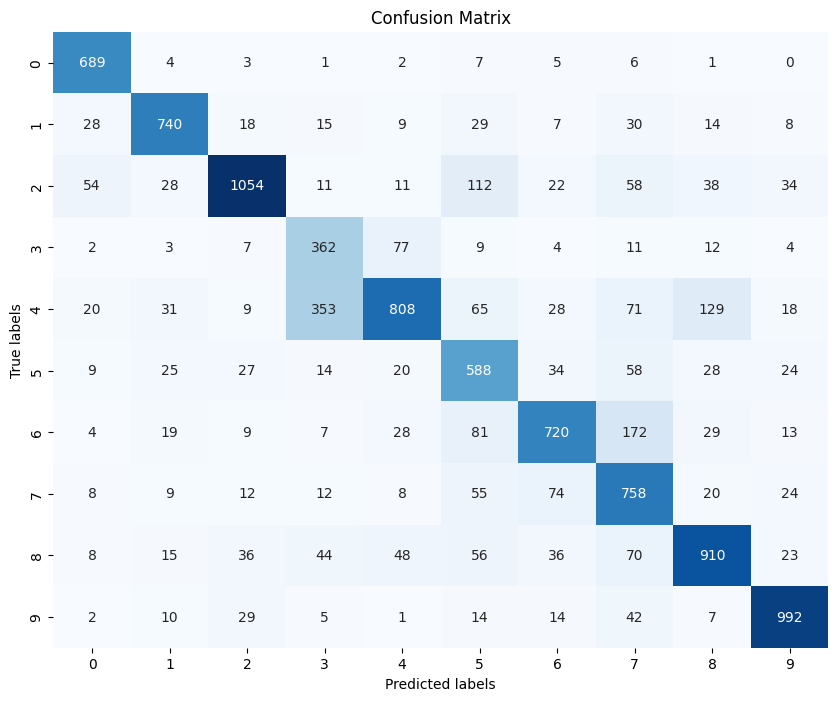

In [3]:
ort_sesh = onnxruntime.InferenceSession("ResNet_aug.onnx")
test_loader = gen_augments(1)

preds = []
grd_tru = []

for images, labels in test_loader:
    images, labels = images.to(device).numpy(), labels.to(device).numpy()
    ort_outputs = ort_sesh.run(None, {'input': images})
    batch_preds = np.argmax(ort_outputs[0], axis=1)
            
    preds.extend(batch_preds)
    grd_tru.extend(labels)

accuracy = accuracy_score(preds, grd_tru)
f1 = f1_score(preds, grd_tru, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)

conf_matrix = confusion_matrix(preds, grd_tru)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [5]:
with wandb.init(project="wildlife_fin_run", config=config):
    wandb.log({"Test Accuracy": accuracy, "Test F1 Score": f1})
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=grd_tru, preds=preds,
                        class_names=classes_RW)})

Test Accuracy,▁
Test F1 Score,▁
Test Accuracy,0.73904
Test F1 Score,0.74097
